CONTRASTIVE ATTENTION FOR ASPECT EXTRACTION

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess

nltk.download('punkt')

# Load your dataset
df = pd.read_csv("uber_reviews_without_reviewid.csv")  # use your actual file path
reviews = df["content"].dropna().tolist()

# Preprocess: tokenize each review
tokenized_reviews = [simple_preprocess(review) for review in reviews]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
pip install --upgrade numpy


  Using cached numpy-2.2.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.5-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy None
Note: you may need to restart the kernel to use updated packages.


error: uninstall-no-record-file

× Cannot uninstall numpy None
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==2.2.4


In [25]:
conda remove --force numpy



SyntaxError: invalid syntax (3599444611.py, line 1)

In [22]:
!pip install gensim


  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl (24.0 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy None


error: uninstall-no-record-file

× Cannot uninstall numpy None
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==2.2.4


In [2]:
from gensim.models import Word2Vec

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=200,   # you can tune this (e.g., 200 or 300)
    window=15,
    min_count=3,       # ignore words with frequency < 2
    workers=4,
    sg=1               # 1 = skip-gram; 0 = CBOW
)

# Save model
w2v_model.save("uber_word2vec.model")


In [3]:
# Load and test
model = Word2Vec.load("uber_word2vec.model")

# See similar words
print(model.wv.most_similar("driver", topn=10))


[('car', 0.8361433744430542), ('arrival', 0.8229877352714539), ('behavior', 0.8201383352279663), ('man', 0.807780385017395), ('condition', 0.804841935634613), ('ride', 0.7997984886169434), ('journey', 0.7944996356964111), ('came', 0.7916377782821655), ('luggage', 0.7900577187538147), ('early', 0.7895087003707886)]


In [4]:
from collections import defaultdict

# Define a few seed canonical aspects
canonical_aspects = [
    "driver", "ride", "app", "fare", "support", "payment",
    "booking",  "car", "interface", "service",
    "map", "location", "tracking", "navigation", "speed",
     "refund", "issue", "experience",
    "agent", "customer", "drop", "pickup", "wallet", "route",
    "destination", "delay", "wait","uber"
]


# Create the aspect mapping dictionary
aspect_mapping = defaultdict(lambda: None)
similarity_threshold = 0.75

# Ensure all keys are lowercase and trimmed
canonical_aspects = [canon.strip().lower() for canon in canonical_aspects]

for canon in canonical_aspects:
    aspect_mapping[canon] = canon  # self-map
    try:
        similar_words = w2v_model.wv.most_similar(canon, topn=10)
        for word, score in similar_words:
            if score > similarity_threshold:
                aspect_mapping[word] = canon
    except KeyError:
        print(f"'{canon}' not in Word2Vec vocabulary — skipped.")
        continue



'speed' not in Word2Vec vocabulary — skipped.


In [5]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")


driver → driver
car → car
arrival → ride
behavior → experience
man → car
condition → driver
ride → ride
journey → experience
came → driver
luggage → car
early → driver
process → ride
passenger → destination
confirmation → ride
increasing → ride
coming → route
night → ride
st → ride
collected → destination
request → ride
app → app
fare → booking
shown → booking
increased → destination
shows → booking
while → fare
showing → fare
distance → booking
initial → booking
fair → booking
increases → fare
different → fare
support → customer
contact → customer
chat → customer
proper → customer
ai → support
resolution → customer
customer → customer
team → support
mail → support
complaint → customer
help → support
payment → payment
upi → wallet
cash → payment
method → wallet
wallet → wallet
mode → wallet
online → payment
pending → wallet
add → wallet
failure → wallet
digital → wallet
booking → booking
increase → booking
reaching → destination
wrost → booking
drove → car
she → car
gentleman → car
hel

In [6]:
seed_vectors = {
    seed: w2v_model.wv[seed] 
    for seed in canonical_aspects 
    if seed in w2v_model.wv
}


In [7]:
# Load manually edited file
refined_df = pd.read_csv("updated_aspect_mappings.csv")

# Convert to dict
aspect_mapping = dict(zip(refined_df["Original_Word"], refined_df["Mapped_Aspect"]))

In [8]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")

driver → driver
car → car
trip → ride
ride → ride
journey → car
she → car
vehicle → car
drive → driver
drove → driver
arrived → wait
rider → driver
bike → car
request → ride
destination → destination
confirmation → ride
increased → fare
rides → ride
app → app
application → app
company → app
experience → experience
aap → app
platform → uber
seen → -
ever → app
services → service
life → experience
travel → service
fare → fare
booking → booking
shown → fare
increase → fare
showing → fare
shows → fare
while → ride
reaching → destination
double → booking
fair → fare
changes → route
support → support
number → customer
contact → support
proper → support
care → support
team → support
help → support
chat → support
customer → customer
issues → support
provide → service
payment → payment
cash → payment
upi → payment
method → payment
online → payment
amount → payment
pending → payment
which → -
mode → payment
wallet → payment
add → payment
price → fare
cab → car
auto → car
booked → booking
initial

In [9]:

aspect_matrix = [w2v_model.wv[word] for word in seed_vectors if word in w2v_model.wv]


In [10]:
import numpy as np

def rbf(x, y, gamma=0.03):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def contrastive_attention(tokens, model, aspect_matrix, gamma=0.03):
    scores = []
    for word in tokens:
        if word in model.wv:
            w_vec = model.wv[word]
            attention = sum(rbf(w_vec, a_vec, gamma) for a_vec in aspect_matrix)
            scores.append((word, attention))
    total = sum(att for _, att in scores)
    if total == 0:
        return []
    return [(word, att / total) for word, att in scores]


In [11]:
# Assuming refined_df is already loaded
# Mapping from word -> canonical aspect
aspect_map = dict(zip(
    refined_df["Original_Word"].str.lower().str.strip(),
    refined_df["Mapped_Aspect"].str.lower().str.strip()
))

def normalize_aspect(word):
    return aspect_map.get(word.lower(), None)



In [12]:
final_aspects = []

for tokens in tokenized_reviews:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.1 and normalize_aspect(w) is not None]
    final_aspects.append(list(set(filtered)))


In [13]:
gold_df= pd.read_csv("Gold_Standard__Only_B-ASP_Considered_.csv")
gold_df

,review,aspect,sentiment,opinion
0,"Efficient, driver is professional, cost is rea...",driver,positive,friendly/nice/polite
1,"Efficient, driver is professional, cost is rea...",fare,positive,cheap/reasonable
2,Waiting charge is extra bad experience,wait,negative,waiting
3,Good service,service,positive,good/great/nice
4,Worst customer service On 19/11/24 I booked an...,driver,neutral,NaN
...,...,...,...,...
104,Don't install this uber app.. totally waste of...,driver,neutral,NaN
105,Don't install this uber app.. totally waste of...,app,neutral,NaN
106,Don't install this uber app.. totally waste of...,service,negative,bad/poor/worst
107,make app user friendly.one can understand easily,app,neutral,NaN


In [ ]:
df_reviews = df["content"].tolist()


In [15]:
from nltk.tokenize import word_tokenize

gold_sentences = [word_tokenize(str(r).lower()) for r in gold_df["review"]]


In [24]:
sent = [word_tokenize(str(r).lower()) for r in df["content"]]



In [25]:
cat_predicted_aspects = []

for tokens in sent:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.1 and normalize_aspect(w) is not None]
    cat_predicted_aspects.append(list(set(filtered)))

In [26]:
df["cat_predicted_aspects"]= cat_predicted_aspects

In [ ]:
# df.to_csv("cat_extracted_aspects",index=True)

In [16]:
gold_predicted_aspects = []

for tokens in gold_sentences:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.1 and normalize_aspect(w) is not None]
    gold_predicted_aspects.append(list(set(filtered)))


In [19]:
gold_df["predicted_aspects_contrastive"] = gold_predicted_aspects


In [17]:
from collections import defaultdict

def group_aspects_by_review(df, review_col="review", aspect_col="aspect"):
    grouped = defaultdict(set)
    for _, row in df.iterrows():
        grouped[row[review_col]].add(row[aspect_col].lower())  # normalize case
    return grouped

gold_aspects = group_aspects_by_review(gold_df)




In [20]:
predicted_aspects = {
    review: set([a.lower() for a in aspects])
    for review, aspects in zip(gold_df["review"], gold_df["predicted_aspects_contrastive"])
}


In [21]:
true_positives = 0
false_positives = 0
false_negatives = 0

comparison_data = []

for review in gold_aspects:
    gold_set = gold_aspects[review]
    pred_set = predicted_aspects.get(review, set())
    
    tp = gold_set & pred_set
    fp = pred_set - gold_set
    fn = gold_set - pred_set

    true_positives += len(tp)
    false_positives += len(fp)
    false_negatives += len(fn)

    comparison_data.append({
        "review": review,
        "gold_aspects": list(gold_set),
        "predicted_aspects": list(pred_set),
        "true_positives": list(tp),
        "false_positives": list(fp),
        "false_negatives": list(fn)
    })

# Create DataFrame for inspection
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)


In [22]:
precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Aspect Extraction Evaluation:\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Aspect Extraction Evaluation:
Precision: 0.719, Recall: 0.422, F1: 0.532


In [23]:
comparison_df

,review,gold_aspects,predicted_aspects,true_positives,false_positives,false_negatives
0,"Efficient, driver is professional, cost is rea...","[driver, fare]","[driver, fare]","[driver, fare]",[],[]
1,Waiting charge is extra bad experience,[wait],"[wait, experience]",[wait],[experience],[]
2,Good service,[service],[service],[service],[],[]
3,Worst customer service On 19/11/24 I booked an...,"[driver, app, service]",[],[],[],"[driver, app, service]"
4,Reliable and timescale and easy tovl use with ...,[fare],[fare],[fare],[],[]
...,...,...,...,...,...,...
78,4 days ago I requested a cash trip for my mom....,[driver],[],[],[],[driver]
79,worst & scam app. Customer ko kam price dikhak...,"[driver, app, fare]",[],[],[],"[driver, app, fare]"
80,Don't install this uber app.. totally waste of...,"[driver, app, service]",[],[],[],"[driver, app, service]"
81,make app user friendly.one can understand easily,[app],"[map, app]",[app],[map],[]


In [27]:
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cat_predicted_aspects
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,[]
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,[]
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,[]
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,[]
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,[]
...,...,...,...,...,...,...,...,...,...,...,...
11995,User_11995,NaN,Excellent!!!,5,0,4.553.10000,2024-11-24 21:59:16,NaN,NaN,4.553.10000,[]
11996,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,"[ride, car, experience]"
11997,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000,[]
11998,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000,[service]


In [28]:
# 1. Replace empty lists with ['uber']
df['cat_predicted_aspects'] = df['cat_predicted_aspects'].apply(
    lambda aspects: ['uber'] if not aspects else aspects
)

In [29]:
# 2. Expand each aspect into a separate row
df_exploded = df.explode('cat_predicted_aspects').reset_index(drop=True)

In [ ]:
# df_exploded.to_csv("cat_extracted_asp",index = True)

performing sentiment analysis using roberta

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load and split data
df = pd.read_csv("cat_extracted_asp_labeled_sent.csv")
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

c:\Users\aayan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
from torch.optim import AdamW


In [32]:

# Custom PyTorch Dataset
class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe['aspect'] + " [SEP] " + dataframe['review']
        self.labels = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts.iloc[idx], 
                                padding='max_length',
                                truncation=True, 
                                max_length=self.max_len,
                                return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [33]:
# Prepare Dataloaders
train_ds = ABSADataset(train_df, tokenizer)
val_ds = ABSADataset(val_df, tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


In [34]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
epochs = 10
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {total_loss:.4f}")

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"Validation Accuracy: {acc:.4f}")


Epoch 1/10 - Training loss: 1.9384
Validation Accuracy: 0.9750
Epoch 2/10 - Training loss: 1.1207
Validation Accuracy: 0.9750
Epoch 3/10 - Training loss: 0.7035
Validation Accuracy: 0.9500
Epoch 4/10 - Training loss: 0.5543
Validation Accuracy: 1.0000
Epoch 5/10 - Training loss: 0.2954
Validation Accuracy: 0.9750
Epoch 6/10 - Training loss: 0.5305
Validation Accuracy: 0.9500
Epoch 7/10 - Training loss: 0.1343
Validation Accuracy: 0.9500
Epoch 8/10 - Training loss: 0.2339
Validation Accuracy: 0.9500
Epoch 9/10 - Training loss: 0.4146
Validation Accuracy: 0.9500
Epoch 10/10 - Training loss: 0.0752
Validation Accuracy: 0.9500


In [38]:
# Save model
model.save_pretrained("roberta_absa_manual")
tokenizer.save_pretrained("roberta_absa_manual")

    

('roberta_absa_manual\\tokenizer_config.json',
 'roberta_absa_manual\\special_tokens_map.json',
 'roberta_absa_manual\\vocab.json',
 'roberta_absa_manual\\merges.txt',
 'roberta_absa_manual\\added_tokens.json')


✅ Validation Accuracy: 0.9500

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      1.00      0.91         5
    Positive       0.95      1.00      0.98        21
     Neutral       1.00      0.86      0.92        14

    accuracy                           0.95        40
   macro avg       0.93      0.95      0.94        40
weighted avg       0.96      0.95      0.95        40



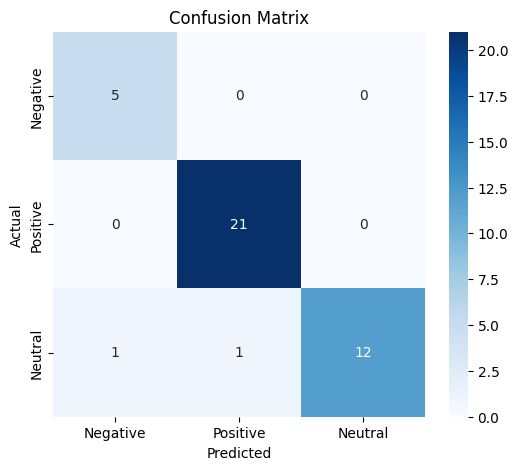

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect true and predicted labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Validation Accuracy: {accuracy:.4f}")

# 2. Detailed Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive", "Neutral"]))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive", "Neutral"],
            yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [41]:

# Load full dataset
df = pd.read_csv("cat_extracted_asp.csv")  # Update with correct path
df = df.dropna(subset=['content', 'cat_predicted_aspects'])

# Load fine-tuned model
model_path = "roberta_absa_manual"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model.eval()
device = torch.device("cpu")
model = model.to(device)

# Predict function
def predict_sentiment(aspect, review):
    text = aspect + " [SEP] " + review
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return {0: "negative", 1: "positive", 2: "neutral"}[pred]

# Run predictions
df['aspect_sentiment'] = df.apply(
    lambda row: predict_sentiment(str(row['cat_predicted_aspects']), str(row['content'])), axis=1
)




In [42]:
df

,Unnamed: 0,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cat_predicted_aspects,aspect_sentiment
0,0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,uber,positive
1,1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,uber,positive
2,2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,uber,neutral
3,3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,uber,positive
4,4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,uber,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13228,13228,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,ride,negative
13229,13229,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,car,negative
13230,13230,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000,uber,neutral
13231,13231,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000,service,positive


In [43]:
# Save result
df.to_csv("cat_extracted_with_sentiment.csv", index=False)
print("✅ Prediction complete. File saved as 'cat_extracted_with_sentiment.csv'")

✅ Prediction complete. File saved as 'cat_extracted_with_sentiment.csv'
